In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# JSON File Helper Function

In [3]:
import graphlab as gl
gl.canvas.set_target('ipynb')

def load_json_from_file(filename):
    """
    Load JSON from a file.
    INPUT:  filename  Name of the file to be read.
    RETURN: Output SFrame
    """
    # Read the entire file into a SFrame with one row
    sf = gl.SFrame.read_csv(filename, delimiter='\n', header=False)
    
    # The dictionary can be unpacked to generate the individual columns.
    sf = sf.unpack('X1', column_name_prefix='')
    return sf

# Import Sport Amazon Review Data

In [5]:
# 3.3 Millions reviews!
Sport = load_json_from_file('/Users/marvinbertin/Desktop/data/reviews_Sports_and_Outdoors.json')

PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/reviews_Sports_and_Outdoors.json
PROGRESS: Parsing completed. Parsed 100 lines in 0.852762 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 87647 lines. Lines per second: 52203.5
PROGRESS: Read 515426 lines. Lines per second: 76801
PROGRESS: Read 943198 lines. Lines per second: 77128.5
PROGRESS: Read 1284612 lines. Lines per second: 73999.4
PROGRESS: Read 1627442 lines. Lines per second: 71502.3
PROGRESS: Read 2065606 lines. Lines per second: 71409.3
PROGRESS: Read 2424790 lines. Lines per second: 69698.2
PROGRESS: Read 2796444 lines. Lines per second: 69670.4
PROGRESS: Read 3073769 lines. Lines per second: 67101.7
PROGRESS: Finished

In [6]:
Sport.show()

## Remove Empty Reviews

In [6]:
# remove empty reviews
Sport = Sport.filter_by(values = '',
                        column_name = 'reviewText',
                        exclude = True)

# Class Imbalance!

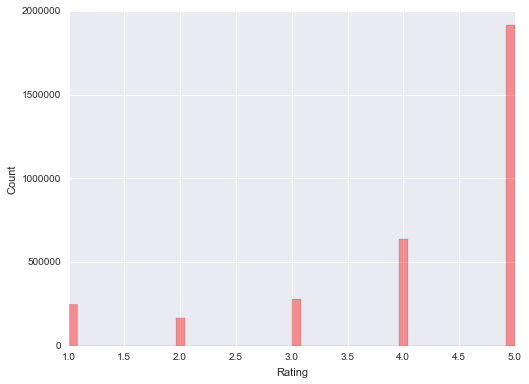

In [7]:
sns.distplot(Sport['overall'], kde = False, color = 'red', norm_hist=False)
plt.ylabel("Count")
plt.xlabel("Rating")
plt.title("");

**What to note:**
* Large majority of Reviews are positive
* A rating of 1 is more common than a rating of 2 (review tend to polarize)

## Down sample positive reviews

In [19]:
indices = []
for rating in range(1, 6):
    idx = Sport['overall'] == rating
    indices.append(idx)
    print str(rating) + ': Count = '+ str(sum(idx))
    

1: Count = 246841
2: Count = 168312
3: Count = 276978
4: Count = 638327
5: Count = 1918569


** Build a SFrame where each rating value has about 200,000 reviews** 

In [23]:
# Shuffle each category to make new sample as unbaised as possible

Sport_balanced = gl.toolkits.cross_validation.shuffle(Sport[indices[0]])[:200000]
for idx in indices[1:]:
    sf = gl.toolkits.cross_validation.shuffle(Sport[idx], random_seed=0)[:200000]
    Sport_balanced = Sport_balanced.append(sf)

In [27]:
Sport_balanced = gl.toolkits.cross_validation.shuffle(Sport_balanced)
Sport_balanced

asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName
B0007VB4NE,"[0, 0]",5.0,I love this chair forusing at my computer. ...,"07 7, 2011",A2TWC2TMTN4MD9,Marcialyn T. Heath
B003HC83BG,"[0, 0]",2.0,My Kindergartener usesthis lock to secure her ...,"05 23, 2014",AP97G6W8E3FH6,Paul Rasmussen
B001FOQV2Q,"[0, 0]",3.0,This is a nice watch. Ilike the two tone of it. ...,"08 20, 2010",A2QU7PCR9W54Y0,The Watch Geek
B002JPCITK,"[1, 2]",2.0,Such a let down! I triedto use this mat last ...,"02 27, 2012",A1FX2FDTXC8A94,Amazon Customer
B003MUILJM,"[0, 0]",2.0,I was looking forward tousing this. The Picture ...,"01 1, 2014",ALOL4WXO3FHYG,Clyde Reynolds
B000GYR9G8,"[0, 0]",3.0,"If you're modest, youmight want to wear ...","07 4, 2010",A3CFLMZUR7IA44,"JP ""J in the US"""
B0027TQMV8,"[6, 6]",5.0,Purchased my first fullcarbon bike and was told ...,"03 27, 2012",A163K7LG1IOCUP,Jonny B
B002I0BJLE,"[0, 0]",4.0,I got these for my 5 yearold daughter and she ...,"07 8, 2013",A1KC1X38LDJS5G,jeremy p phipps
B008E15LE2,"[1, 8]",2.0,"If I receive wat I askfor, I don't like it too ...","11 26, 2012",A3DYS4CZJRHY0C,Ricardo
B003PBHLKS,"[0, 0]",5.0,"quality is not very good,but it's good enough for ...","01 10, 2013",A2BQT84E06XOO4,Evilsanta


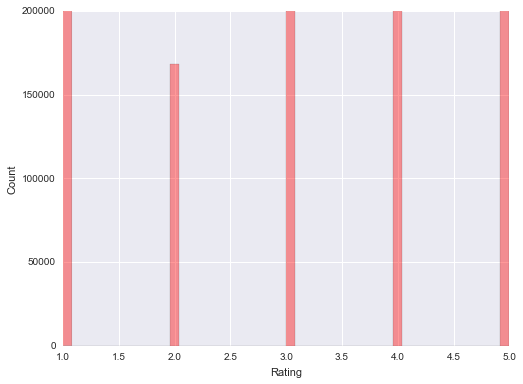

In [28]:
sns.distplot(Sport_balanced['overall'], kde = False, color = 'red')
plt.ylabel("Count")
plt.xlabel("Rating")
plt.title("");

# Export Balanced Dataset to JSON

In [29]:
Sport_balanced.export_json(filename = '/Users/marvinbertin/Desktop/data/Sport_balanced', orient = 'lines')

# Load JSON File

In [6]:
Sport_balanced = load_json_from_file('/Users/marvinbertin/Desktop/data/Sport_balanced')

PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/Sport_balanced
PROGRESS: Parsing completed. Parsed 100 lines in 0.817894 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 86389 lines. Lines per second: 52534
PROGRESS: Read 603901 lines. Lines per second: 79796.4
PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/Sport_balanced
PROGRESS: Parsing completed. Parsed 968312 lines in 12.5561 secs.


# Data Exploration

In [8]:
# Green: num. of review per items
# Yellow: mean rating per items
# Purple: Std of ratings per items
Sport_balanced.show(view = 'Bar Chart', x = 'asin')

**What to note:**
* Number of reviews per item varies wildly, from a dozen to thousands of reviews.
* Mean rating is nicely distributed (balanced)
* Mean rating has low variance (std ~ 1.0). Most reviewers agree with eachother

In [9]:
# Green: num. of review per reviewer
# Yellow: mean rating per reviewer
# Purple: Std of ratings per reviewer
Sport_balanced.show(view = 'Bar Chart', x = 'reviewerID')

**What to note:**
* Large majority of Reviewer only give at most 1 review
* Max number of review is around 20
* Mean rating is again nicely distributed (balanced)
* A Reviewer's ratings has low variance (std ~ 1.0). Most reviewers either only complain or only praise

# Feature Engineering

In [10]:
# Only keep features of interest
Sport_sf = Sport_balanced[['overall', 'reviewText', 'summary']]

## Binary Sentiement Feature
** Let's get rid of ratings = 3 (assumed neutral) for the moment being**

In [ ]:
def binarize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return

In [11]:
Sport_sf = Sport_sf[Sport_sf['overall'] != 3]

In [13]:
Sport_sf.add_column(data = Sport_sf['overall'] > 3, name = 'sentiment')

overall,reviewText,summary,sentiment
5,I love this chair forusing at my computer. ...,Great chair,1
2,My Kindergartener usesthis lock to secure her ...,Falls apart and getsstuck ...,0
2,Such a let down! I triedto use this mat last ...,So slippery!,0
2,I was looking forward tousing this. The Picture ...,Too Bad,0
5,Purchased my first fullcarbon bike and was told ...,Great Tool,1
4,I got these for my 5 yearold daughter and she ...,Big Hit with my Daughter,1
2,"If I receive wat I askfor, I don't like it too ...",Wasn't wat i wan't,0
5,"quality is not very good,but it's good enough for ...",good enough,1
2,"In the description itsays it fits a 48"" waist ...","48"" waist? I think not",0
5,"This Watch is Sharp!, itlooks a lot like a Watch ...",Worth Every Penny in TheGold Box ...,1


In [15]:
Sport_sf.export_json(filename = '/Users/marvinbertin/Desktop/data/Sport_sentiment', orient = 'lines')

# Unigram

In [17]:
Sport_review = Sport_sf[['reviewText', 'sentiment']]
Sport_review.add_column(gl.text_analytics.count_ngrams(Sport_review['reviewText'], n = 1),
                        name = 'Unigram')

reviewText,sentiment,Unigram
I love this chair forusing at my computer. ...,1,"{'and': 1, 'purported':1, 'love': 1, 'help': 1, ..."
My Kindergartener usesthis lock to secure her ...,0,"{'and': 2, 'secure': 1,'lock': 4, 'is': 1, ..."
Such a let down! I triedto use this mat last ...,0,"{'and': 3, 'pose': 1,'within': 1, 'cheap': 1, ..."
I was looking forward tousing this. The Picture ...,0,"{'and': 1, 'right': 2,'is': 1, 'it': 1, ..."
Purchased my first fullcarbon bike and was told ...,1,"{'cyclers': 1, 'bike': 1,'all': 1, 'bicycle': 2, ..."
I got these for my 5 yearold daughter and she ...,1,"{'and': 3, 'old': 1,'thus': 1, 'are': 1, ..."
"If I receive wat I askfor, I don't like it too ...",0,"{'don': 1, 'like': 1,'for': 1, 'that': 2, ..."
"quality is not very good,but it's good enough for ...",1,"{'and': 1, 'deal': 1,'is': 1, 'cheap': 1, ..."
"In the description itsays it fits a 48"" waist ...",0,"{'and': 1, 'work': 1,'wear': 2, 'have': 1, ..."
"This Watch is Sharp!, itlooks a lot like a Watch ...",1,"{'150': 1, 'all': 1,'because': 1, 'love': 1, ..."


# Bigram

In [18]:
Sport_review.add_column(gl.text_analytics.count_ngrams(Sport_review['reviewText'], n = 2),
                        name = 'Bigram')

reviewText,sentiment,Unigram,Bigram
I love this chair forusing at my computer. ...,1,"{'and': 1, 'purported':1, 'love': 1, 'help': 1, ...","{'second one': 1, 'seeit': 1, 'help your': 1, ..."
My Kindergartener usesthis lock to secure her ...,0,"{'and': 2, 'secure': 1,'lock': 4, 'is': 1, ...","{'at school': 1, 'cablethe': 1, 'word lock': 1, ..."
Such a let down! I triedto use this mat last ...,0,"{'and': 3, 'pose': 1,'within': 1, 'cheap': 1, ...","{'target the': 1, 'withmy': 1, 'mat and': 1, 'a ..."
I was looking forward tousing this. The Picture ...,0,"{'and': 1, 'right': 2,'is': 1, 'it': 1, ...","{'the picture': 1,'change it': 1, 'i was': ..."
Purchased my first fullcarbon bike and was told ...,1,"{'cyclers': 1, 'bike': 1,'all': 1, 'bicycle': 2, ...","{'it in': 1, 'at the': 1,'price i': 1, 'handle ..."
I got these for my 5 yearold daughter and she ...,1,"{'and': 3, 'old': 1,'thus': 1, 'are': 1, ...","{'been pretty': 1, 'sheloves': 1, 'loves them': ..."
"If I receive wat I askfor, I don't like it too ...",0,"{'don': 1, 'like': 1,'for': 1, 'that': 2, ...","{'for i': 1, 'that is':1, 'i ask': 1, 'if i' ..."
"quality is not very good,but it's good enough for ...",1,"{'and': 1, 'deal': 1,'is': 1, 'cheap': 1, ...","{'ski no': 1, 'is not':1, 's good': 1, 'for a': ..."
"In the description itsays it fits a 48"" waist ...",0,"{'and': 1, 'work': 1,'wear': 2, 'have': 1, ...","{'with it': 1, 'it in':1, 'if you': 1, 'broader ..."
"This Watch is Sharp!, itlooks a lot like a Watch ...",1,"{'150': 1, 'all': 1,'because': 1, 'love': 1, ...","{'so good': 1, 'swissmovement': 1, 'watch p': ..."


# Word Feature Model

** Start with a simplistic model (Baseline), then increase model complexity **

In [19]:
sentiment_words = ['awesome', 'great', 'fantastic', 'amazing', 'love',
                  'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [20]:
def sentiment_word_count(unigram, word):
    if word in unigram:
        return unigram[word]
    else:
        return 0

## Frequency Table of Positive and Negative Words

In [21]:
freq_table = gl.SFrame({'sentiment': Sport_review['sentiment']})

for word in sentiment_words:
    freq_table[word] = Sport_review['Unigram'].apply(lambda unigram: sentiment_word_count(unigram, word))

In [22]:
freq_table.head()

sentiment,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate
1,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0


## Words with highest count

In [23]:
freq_count = []
for word in sentiment_words:
    freq_count.append(freq_table[word].sum())

In [35]:
word_freq = zip(sentiment_words, freq_count)
word_freq.sort(key = lambda t: t[1], reverse=True)

for w, f in word_freq:
    print "'{}' occurs {} times.".format(w, f)

'great' occurs 184131 times.
'love' occurs 54885 times.
'bad' occurs 34779 times.
'awesome' occurs 13277 times.
'terrible' occurs 8285 times.
'amazing' occurs 7327 times.
'horrible' occurs 6702 times.
'fantastic' occurs 4648 times.
'hate' occurs 4516 times.
'awful' occurs 3119 times.
'wow' occurs 2475 times.


# Logistic Classifier 

In [36]:
freq_train, freq_test = freq_table.random_split(0.8, seed=0)

In [38]:
feature_words_model = gl.logistic_classifier.create(freq_train,
                                                    target = 'sentiment',
                                                    features= sentiment_words,
                                                    validation_set = freq_test)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 614877
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 11
PROGRESS: Number of unpacked features : 11
PROGRESS: Number of coefficients    : 12
PROGRESS: Starting Newton Method
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 2        | 1.940671     | 0.622944          | 0.623991            |
PROGRESS: | 2         | 3        | 2.526519     | 0.622972          | 0.624062            |
PROGRESS: | 3         | 4        | 3.123392     | 0.623043          | 0.624030            |
PROGRESS: | 4         | 5        |

## Feature Coefficients

In [39]:
feature_words_model['coefficients'].sort('value')

name,index,class,value
horrible,None,1,-2.25928644233
terrible,None,1,-2.20243828841
awful,None,1,-1.97612582374
hate,None,1,-0.79701408614
bad,None,1,-0.773396493599
(intercept),None,1,-0.177002708824
wow,None,1,-0.0485853523986
great,None,1,1.11010078649
fantastic,None,1,1.1356489797
awesome,None,1,1.15027219252


** what to note:**
* Negative words have negative coefficents
* Positive words have positive coefficients (except "wow")
* Negative words like "horrible" and "terrible" have twice the magnitude of the most positive words (negative words seem to have stronger connotation)

## Model Evaluation

In [42]:
def print_statistics(result):
    print "*" * 30
    print "Accuracy        : ", result["accuracy"]
    print "Precision       : ", result['precision']
    print "Recall          : ", result['recall']
    print "AUC             : ", result['auc']
    print "Confusion Matrix: \n", result["confusion_matrix"]

In [43]:
feature_word_result = feature_words_model.evaluate(freq_test)
print_statistics(feature_word_result)

******************************
Accuracy        :  0.624029719425
Precision       :  0.788659527135
Recall          :  0.381076182739
AUC             :  0.656706547595
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        |  8170 |
|      0       |        0        | 65260 |
|      1       |        1        | 30488 |
|      1       |        0        | 49517 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



** what to note:**
* Performance not very impressive
* Specific word features are too bias to make the model useful
* Review with zero count for all features has by default a negative predicted sentiment

# Sentiment Anlaysis - Summary Unigram
** Review summary are only a few word long, but may provide enough information for sentiment analysis**

In [51]:
Sport_summary = Sport_sf[['sentiment', 'summary']]
Sport_summary.add_column(gl.text_analytics.count_ngrams(Sport_summary['summary'], n = 1),
                        name = 'Unigram')

sentiment,summary,Unigram
1,Great chair,"{'chair': 1, 'great': 1}"
0,Falls apart and getsstuck ...,"{'and': 1, 'stuck': 1,'gets': 1, 'falls': 1, ..."
0,So slippery!,"{'so': 1, 'slippery': 1}"
0,Too Bad,"{'bad': 1, 'too': 1}"
1,Great Tool,"{'tool': 1, 'great': 1}"
1,Big Hit with my Daughter,"{'hit': 1, 'with': 1,'my': 1, 'daughter': 1, ..."
0,Wasn't wat i wan't,"{'i': 1, 'wan': 1, 'wat':1, 't': 2, 'wasn': 1} ..."
1,good enough,"{'enough': 1, 'good': 1}"
0,"48"" waist? I think not","{'not': 1, 'i': 1,'think': 1, '48': 1, ..."
1,Worth Every Penny in TheGold Box ...,"{'box': 1, 'gold': 1,'penny': 1, 'every': 1, ..."


# Train Logisictic Classifier

In [52]:
SportS_train, SportS_test = Sport_summary.random_split(0.8, seed=0)

In [53]:
# Automatically take validation set for tuning
SS_1gram_model = gl.logistic_classifier.create(SportS_train[['sentiment', 'Unigram']],
                                              target = 'sentiment',
                                              features=['Unigram'], 
                                              l2_penalty=0.01,
                                              max_iterations = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 584086
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 46250
PROGRESS: Number of coefficients    : 46251
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000002  | 0.793782     | 0.869880          | 0.849664            |
P

## Model Evaluation

In [54]:
resultS_1gram = SS_1gram_model.evaluate(SportS_test)
print_statistics(resultS_1gram)

******************************
Accuracy        :  0.874233388731
Precision       :  0.869359941592
Recall          :  0.892994187863
AUC             :  0.934993589661
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        0        | 62694 |
|      0       |        1        | 10736 |
|      1       |        0        |  8561 |
|      1       |        1        | 71444 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



** What to note:**
* Massive increase in performance across all metrics
* Drastic increase in number of features to 46,250!

# Sentiment Anlaysis - Review Unigram

In [44]:
Sport_train, Sport_test = Sport_review.random_split(0.8, seed=0)

In [55]:
# Automatically take validation set for tuning
S_1gram_model = gl.logistic_classifier.create(Sport_train[['sentiment', 'Unigram']],
                                              target = 'sentiment',
                                              features=['Unigram'], 
                                              l2_penalty=0.01,
                                              max_iterations = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 584574
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 181828
PROGRESS: Number of coefficients    : 181829
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000002  | 3.209574     | 0.876604          | 0.859057            |

## Unigram Evaluation

In [56]:
result_1gram = S_1gram_model.evaluate(Sport_test)

In [57]:
print_statistics(result_1gram)

******************************
Accuracy        :  0.881435135399
Precision       :  0.876885555759
Recall          :  0.898806324605
AUC             :  0.941310291166
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        | 10096 |
|      0       |        0        | 63334 |
|      1       |        1        | 71909 |
|      1       |        0        |  8096 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



** what to note:**
* Small improvement in performance all metrics increased, but by no more than 1%
* However number of features quadrupled to 181,828!
* The review summary is more dense in signal, while the full review is more noisy (more wordy).

# Sentiment Anlaysis - Review Unigram & Bigram
** Just for fun let's add a bigram in the mix and watch the number of features blow up!**

In [58]:
# Automatically take validation set for tuning
S_1_2gram_model = gl.logistic_classifier.create(Sport_train[['sentiment', 'Unigram', 'Bigram']],
                                              target = 'sentiment',
                                              features=['Unigram', 'Bigram'], 
                                              l2_penalty=0.03,
                                              max_iterations = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 583996
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 2
PROGRESS: Number of unpacked features : 4085547
PROGRESS: Number of coefficients    : 4085548
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000002  | 11.850290    | 0.967055          | 0.894854           

## Model Evaluation

In [59]:
result_1_2gram = S_1_2gram_model.evaluate(Sport_test)
print_statistics(result_1_2gram)

******************************
Accuracy        :  0.904611073093
Precision       :  0.901514686191
Recall          :  0.917267670771
AUC             :  0.958647734404
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        |  8017 |
|      0       |        0        | 65413 |
|      1       |        1        | 73386 |
|      1       |        0        |  6619 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



** what to note:**
* The increase in performance is pretty good (AUC: 0.959)
* This is at the cost of keeping track of 4,085,548 features!

# Plot ROC Curve

In [60]:
S_1_2gram_model.show(view='Evaluation')

** What to note:**
* The ROC shows that our model is a great sentiment classifier
* Since Flase Negatives aren't prefered over False Positive, the optimal threshold is about 0.5

** BUT is there a way to obtain similar performance with a simpler model?**

# Word2Vect

In [63]:
from numpy import average
import os
import gensim
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [ ]:
BASE_DIR = "/Users/marvinbertin/graphlab_data/Bags-of-Popcorn"
os.mkdir("%s/txt" % BASE_DIR)
train_data.apply(lambda r: file("%s/txt/%s.txt" % (BASE_DIR, r["id"]),"w").write(r['review'])).__materialize__()

In [ ]:
sentences = TrainSentences("%s/LabeledData" % BASE_DIR)
model = gensim.models.Word2Vec(sentences, size=300, workers=4, min_count=40, window=8)
model.save("%s/movie_fullreviews_300_c_40_w_8.word2vec" % BASE_DIR)